In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels
import scipy
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import scipy.stats
import pylab
import matplotlib as mpl
from scipy.stats.distributions import chi2
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import norm
sns.set()

In [6]:
raw_index_data=pd.read_csv('Index2018.csv')  # Index price data Importation in Raw_index_data variable
df_index=raw_index_data.copy()  # copy to df_index from Raw_index_data
df_index.date=pd.to_datetime(df_index.date,dayfirst=True) # datatype of date column changed to datetime 
df_index.set_index('date',inplace=True) # set date column as index
df_index=df_index.asfreq('b') # setting frequency of data obsevation to business days
df_index.shape #shape checking 

(6277, 4)

In [7]:
df_index.spx.fillna(method='ffill',inplace=True) # front filling of missing values of spx columns
df_index.ftse.fillna(method='bfill',inplace=True) # backfilling of missing values of ftse columns
df_index.dax.fillna(df_index.dax.mean(),inplace=True) # mean value assigned to each missing values of dax columns 
df_index.nikkei.fillna(df_index.nikkei.median(),inplace=True) # median value assigned to each missing value of nikkei

In [8]:
df_market_value=df_index[['ftse']] # Selecting FTSE index for further processing
df_market_value.rename(columns={'ftse':'market_value'},inplace=True) # renaming ftse to market value
traininglen=int(len(df_market_value)*0.8) # Train and test split with ratio of 80:20
testingLen=len(df_market_value)-traininglen
df_market_value_train=df_market_value.iloc[:traininglen,:]
df_market_value_test=df_market_value.iloc[traininglen:,:]

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [9]:
mean=df_market_value_train['market_value'].mean() # calculating mean of ftse market index values from training part of dataset
std=df_market_value_train['market_value'].std() # calculating std from same
wn=np.random.normal(loc=mean,scale=std,size=len(df_market_value_train)) # creating white noice using np.random.uniform()
df_market_value_train['wn']=wn 

C:\Users\adadi\AppData\Local\Temp/ipykernel_18828/2511373873.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_market_value_train['wn']=wn


In [10]:
rw=pd.read_csv('RandWalk.csv') # adding new column for random walk in training dataframe  
rw.date=pd.to_datetime(rw.date,dayfirst=True)
rw.set_index('date',inplace=True)
df_market_value_train=pd.merge(left=df_market_value_train,right=rw,left_index=True, right_index=True)
df_market_value_train.rename(columns={'price':'rw'},inplace=True) # renaming the randomwalk value column

In [11]:
df_market_value_train.head()

,market_value,wn,rw
date,,,
1994-01-07,3445.98,6726.195312,1122.139662
1994-01-10,3440.58,4984.228999,1080.347860
1994-01-11,3413.77,5420.528832,1082.095245
1994-01-12,3372.02,4432.994230,1083.639265
1994-01-13,3360.01,5633.988855,1067.146255


#### ***ARIMA***
- The order of ARIMA model takes 3 elements. two of them is simialar as we are taking for normal ARMA model.
- But one extra term, that is used, is called intergration term.
- The intergration term bascically says that how many times model hiddenly calculate the difference of consecutive element, so that final series will become stationary, since normal ARMA model performs well with stationary data.
- This is only difference from normal ARMA model.
- denoted by ARIMA(p,d,q).
- Depend upon the value of the d we will loose same no of data from beginning.
- Lets fit the ftse index price here.

In [12]:
model_ar1_i_1_ma1=ARIMA(df_market_value_train['market_value'],order=(1,1,1))
result_ar1_i_1_ma1=model_ar1_i_1_ma1.fit()
print(result_ar1_i_1_ma1.summary())

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-

                               SARIMAX Results                                
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -27604.051
Date:                Sat, 26 Oct 2024   AIC                          55214.102
Time:                        18:15:12   BIC                          55233.666
Sample:                    01-07-1994   HQIC                         55220.958
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7460      0.059     12.638      0.000       0.630       0.862
ma.L1         -0.7919      0.053    -14.899      0.000      -0.896      -0.688
sigma2      3497.2506     40.894     85.521      0.0

In [13]:
df_market_value_train['resid_ar1_i1_ma1']=result_ar1_i_1_ma1.resid

In [14]:
adfuller(df_market_value_train.resid_ar1_i1_ma1)

(-25.42558217132577,
 0.0,
 7,
 5013,
 {'1%': -3.431655136974821,
  '5%': -2.8621167297421373,
  '10%': -2.567076993884522},
 54861.289908506835)

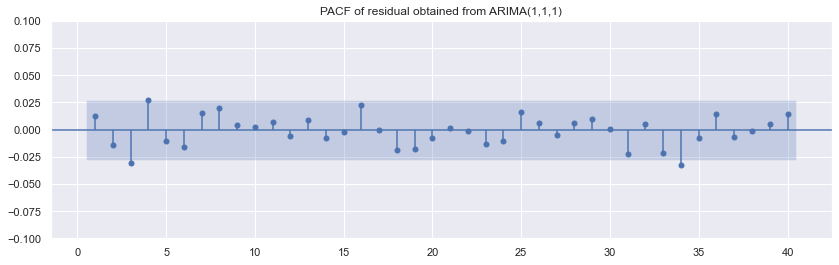

In [15]:
plt.rc('figure',figsize=(14,4))
sgt.plot_pacf(df_market_value_train['resid_ar1_i1_ma1'],zero=False,lags=40,method='ols',alpha=0.05)
plt.title('PACF of residual obtained from ARIMA(1,1,1)')
plt.ylim((-0.1,0.1))
plt.show()

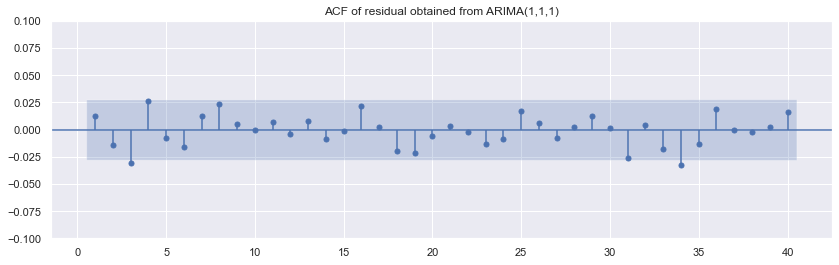

In [16]:
plt.rc('figure',figsize=(14,4))
sgt.plot_acf(df_market_value_train['resid_ar1_i1_ma1'],zero=False,lags=40,alpha=0.05)
plt.title('ACF of residual obtained from ARIMA(1,1,1)')
plt.ylim((-0.1,0.1))
plt.show()

#### ***Observation***
- Coefficient observed in arima(1,1,1) Model fitted on market value of ftse are same as ARMA(1,1) fitten on return data of FTSE market value.
- By observing the residual obtained from ARMA(1,1,1) ,it is clear that it is a white noice, resembles with normal distribution, which indicates that, all the past pattern has been learnt properly.
- But there still exist some significant correlation between current residual with the lag upto 8.
- So lets find a better model.
- IN last notebook we have observed that ARMA(1,1),(1,2),(1,3),(2,1),(3,1),(3,2),(3,3),(5,1),(5,2) has performed well in return ftse index price. 

### ***Fitting all the possible ARIMA model***

In [17]:
model_ar1_i1_ma2=ARIMA(df_market_value_train['market_value'],order=(1,1,2))
result_ar1_i1_ma2=model_ar1_i1_ma2.fit()

model_ar1_i1_ma3=ARIMA(df_market_value_train['market_value'],order=(1,1,3))
result_ar1_i1_ma3=model_ar1_i1_ma3.fit()

model_ar2_i1_ma1=ARIMA(df_market_value_train['market_value'],order=(2,1,1))
result_ar2_i1_ma1=model_ar2_i1_ma1.fit()

model_ar3_i1_ma1=ARIMA(df_market_value_train['market_value'],order=(3,1,1))
result_ar3_i1_ma1=model_ar3_i1_ma1.fit()

model_ar3_i1_ma2=ARIMA(df_market_value_train['market_value'],order=(3,1,2))
result_ar3_i1_ma2=model_ar3_i1_ma2.fit()

model_ar3_i1_ma3=ARIMA(df_market_value_train['market_value'],order=(3,1,3))
result_ar3_i1_ma3=model_ar3_i1_ma3.fit()

model_ar5_i1_ma1=ARIMA(df_market_value_train['market_value'],order=(5,1,1))
result_ar5_i1_ma1=model_ar5_i1_ma1.fit()

model_ar5_i1_ma2=ARIMA(df_market_value_train['market_value'],order=(5,1,2))
result_ar5_i1_ma2=model_ar5_i1_ma2.fit()


C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473

### Lets compare The All the model by their LLf, AIC

In [18]:
print(f'ModelName: ARIMA(1,1,1)  \tLL: {result_ar1_i_1_ma1.llf} \t AIC: {result_ar1_i_1_ma1.aic}')
print(f'ModelName: ARIMA(1,1,2)  \tLL: {result_ar1_i1_ma2.llf}  \t AIC: {result_ar1_i1_ma2.aic}')
print(f'ModelName: ARIMA(1,1,3)  \tLL: {result_ar1_i1_ma3.llf}  \t AIC: {result_ar1_i1_ma3.aic}')
print(f'ModelName: ARIMA(2,1,1)  \tLL: {result_ar2_i1_ma1.llf}  \t AIC: {result_ar2_i1_ma1.aic}')
print(f'ModelName: ARIMA(3,1,1)  \tLL: {result_ar3_i1_ma1.llf}  \t AIC: {result_ar3_i1_ma1.aic}')
print(f'ModelName: ARIMA(3,1,2)  \tLL: {result_ar3_i1_ma2.llf}  \t AIC: {result_ar3_i1_ma2.aic}')
print(f'ModelName: ARIMA(3,1,3)  \tLL: {result_ar3_i1_ma3.llf}  \t AIC: {result_ar3_i1_ma3.aic}')
print(f'ModelName: ARIMA(5,1,1)  \tLL: {result_ar5_i1_ma1.llf}  \t AIC: {result_ar5_i1_ma1.aic}')
print(f'ModelName: ARIMA(5,1,2)  \tLL: {result_ar5_i1_ma2.llf}  \t AIC: {result_ar5_i1_ma2.aic}')



ModelName: ARIMA(1,1,1)  	LL: -27604.051173549968 	 AIC: 55214.102347099935
ModelName: ARIMA(1,1,2)  	LL: -27600.47033798942  	 AIC: 55208.94067597884
ModelName: ARIMA(1,1,3)  	LL: -27591.904204384413  	 AIC: 55193.808408768826
ModelName: ARIMA(2,1,1)  	LL: -27600.197766076282  	 AIC: 55208.395532152565
ModelName: ARIMA(3,1,1)  	LL: -27593.41636599207  	 AIC: 55196.83273198414
ModelName: ARIMA(3,1,2)  	LL: -27592.178989307067  	 AIC: 55196.357978614134
ModelName: ARIMA(3,1,3)  	LL: -27588.405784087827  	 AIC: 55190.81156817565
ModelName: ARIMA(5,1,1)  	LL: -27587.943443519584  	 AIC: 55189.88688703917
ModelName: ARIMA(5,1,2)  	LL: -27585.507119672067  	 AIC: 55187.014239344135


#### ***Observation***
- Model with order value(5,1,2) has performed well. but we can not choose it as best model for now since it has total 6 parameter which can make it complecated.
- So Let compare the significance of performance obtained from each model from higher lag. if there wont be existing any significant performance difference between two model then simple model with lower lag will be selected.

In [19]:
def LLR_test(Model_a_res,Model_b_res,df=1):
    La=Model_a_res.llf
    Lb=Model_b_res.llf
    Q=2*(Lb-La)
    P=chi2.sf(Q,df)
    return P 

### ***LLR Test***

In [20]:
print('LLR test of ARIMA(5,1,1) AND ARIMA(5,1,2):\t',LLR_test(result_ar5_i1_ma1,result_ar5_i1_ma2))
print('LLR test of ARIMA(1,1,2) AND ARIMA(5,1,2):\t',LLR_test(result_ar1_i1_ma2,result_ar5_i1_ma2,df=1))
print('LLR test of ARIMA(3,1,2) AND ARIMA(5,1,2):\t',LLR_test(result_ar3_i1_ma2,result_ar5_i1_ma2,df=1))

LLR test of ARIMA(5,1,1) AND ARIMA(5,1,2):	 0.027285605659301094
LLR test of ARIMA(1,1,2) AND ARIMA(5,1,2):	 4.487523426117635e-08
LLR test of ARIMA(3,1,2) AND ARIMA(5,1,2):	 0.00025928681545271166


#### ***Observation***
- By Performing LLR test we can cleary says that model ARMA(5,1,2) has performed significantly well than other with lower total lags this.

### ***Analysis of the residual***

In [21]:
df_market_value_train['resid_ar5_i1_ma2']=result_ar5_i1_ma2.resid

In [22]:
adfuller(df_market_value_train['resid_ar5_i1_ma2'])

(-91.93165382744634,
 0.0,
 0,
 5020,
 {'1%': -3.431653316130827,
  '5%': -2.8621159253018247,
  '10%': -2.5670765656497516},
 54847.90210608275)

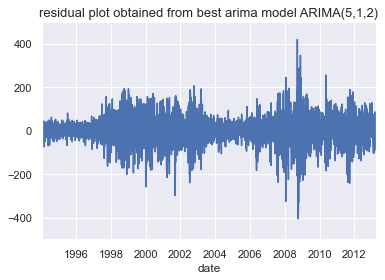

In [23]:
plt.rc('figure',figsize=(6,4))
df_market_value_train.resid_ar5_i1_ma2.plot()
plt.title('residual plot obtained from best arima model ARIMA(5,1,2)',size=13)
plt.ylim((-500,500))
plt.show()

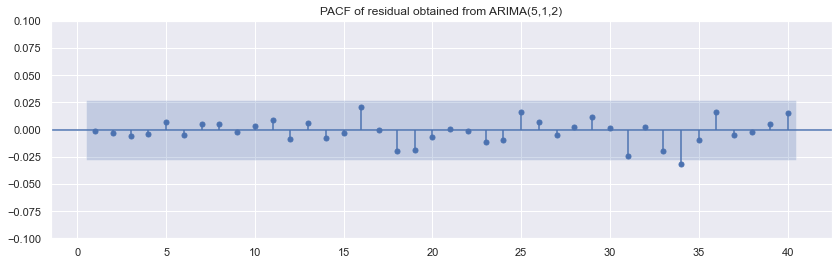

In [24]:
plt.rc('figure',figsize=(14,4))
sgt.plot_pacf(df_market_value_train['resid_ar5_i1_ma2'],zero=False,lags=40,method='ols',alpha=0.05)
plt.title('PACF of residual obtained from ARIMA(5,1,2)')
plt.ylim((-0.1,0.1))
plt.show()

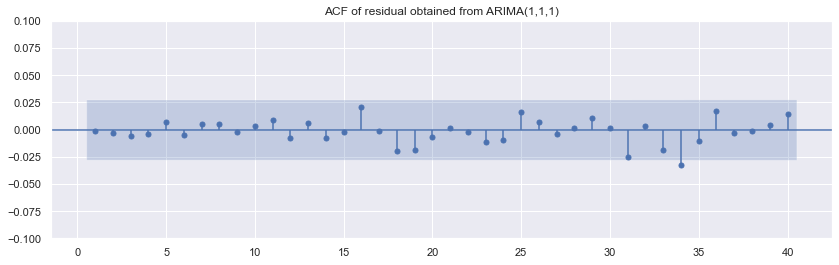

In [25]:
plt.rc('figure',figsize=(14,4))
sgt.plot_acf(df_market_value_train['resid_ar5_i1_ma2'],zero=False,lags=40,alpha=0.05)
plt.title('ACF of residual obtained from ARIMA(1,1,1)')
plt.ylim((-0.1,0.1))
plt.show()

In [26]:
mean,std=df_market_value_train.resid_ar5_i1_ma2.mean(),df_market_value_train.resid_ar5_i1_ma2.std()
mean,std

(1.3507267269634617, 76.38862703671055)

In [27]:
ci=norm.interval(alpha=0.997,loc=mean,scale=std)
ci

(-225.35069879467113, 228.0521522485972)

#### ***Observation And conlusion***
- Since in term of log likelihood, AIC Value and LLR test we conclude that model ARIMA(5,1,2) has peformed well.
- by analyzing the residual obtained from selected model it is clear that the residuals are white noice cause. it has passed adfuller test of stationarity. and pacf and acf plot says that residual has no significant correlation with residuals at previous lags. So distribution of residual must be resembles with normal distribution.
- by observing mean, std and approximate distribution of the residual we can says that 99.7 percent of time model will make error between (-225.35 , 228.08).
- So the investor should be able to take the risk of this range if they make investment decision by relying on this model, ARIMA(5,1,2).

## ARIMAX
- This is the model which take more than just past values and past residuals into account to predict future value accurately.
- That extra feature is called Exogenous variable. the exogenous variable can be anything  for example.
  - a time measurement.
  - other index price,
  - categorical variable.
  - boolean variable.
  - combination of several different variable.
- Is denoted by beta*X: where Beta= coefficient based on model selected and data. and X is the exogenous variable that can affect prices.
- Lets take an example where we will try to predict future value of ftse market index by taking price of S&P as exogenous variable.

In [28]:
model_ar1_i1_ma1_Xspx=ARIMA(df_market_value_train['market_value'],freq='B',order=(1,1,1),exog=df_index.iloc[0:df_market_value_train.shape[0],0])
result_ar1_i1_ma1_Xspx=model_ar1_i1_ma1_Xspx.fit()
print(result_ar1_i1_ma1_Xspx.summary())

                               SARIMAX Results                                
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -26701.787
Date:                Sat, 26 Oct 2024   AIC                          53411.574
Time:                        18:15:39   BIC                          53437.659
Sample:                    01-07-1994   HQIC                         53420.715
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
spx            2.6867      0.035     76.009      0.000       2.617       2.756
ar.L1          0.2504      0.029      8.569      0.000       0.193       0.308
ma.L1         -0.5409      0.025    -21.515      0.0

In [29]:
print(f'ModelName: ARIMAX(1,1,1)  \tLL: {result_ar1_i1_ma1_Xspx.llf}  \t AIC: {result_ar1_i1_ma1_Xspx.aic}')
print(f'ModelName: ARIMA(1,1,1)  \tLL: {result_ar1_i_1_ma1.llf}  \t AIC: {result_ar1_i_1_ma1.aic}')
print(f'ModelName: ARIMA(5,1,2)  \tLL: {result_ar5_i1_ma2.llf}  \t AIC: {result_ar5_i1_ma2.aic}')


ModelName: ARIMAX(1,1,1)  	LL: -26701.78702864993  	 AIC: 53411.57405729986
ModelName: ARIMA(1,1,1)  	LL: -27604.051173549968  	 AIC: 55214.102347099935
ModelName: ARIMA(5,1,2)  	LL: -27585.507119672067  	 AIC: 55187.014239344135


### ***Observation***
- From above comparion of log likelihood and Aci it is clear that ARIMAX(1,1,1) with exogenous variable S&P data is better performing that normal ARIMA(1,1,1).
- This ARIMAX model even performing far better than best model found in the ARIMA() paradigm.